# Examining Conceptual Behavior in V+L Models

In [33]:
from pathlib import Path
import pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import spearmanr
import torch
from torchmetrics.functional import accuracy, coverage_error, recall

from fsk.config import layers, feature_types, multi_models_info
from fsk.dataprep.utils import get_synsets_ids, get_fsk, get_fsk_features, get_feature_idx_map
from fsk.it_match.load import get_match, get_concept_match_distance, get_feature_match_distance
from fsk.similarity.sem_distances import get_mcrae_features

To run locally, define the directory containing the project's data:

In [34]:
project_path =  Path('/Users/m_vilas/projects/fsk-multimodal')

In [35]:
res_path = project_path / 'results'

In [36]:
# Load synsets and concepts
synsets_imgs, concepts = get_synsets_ids(project_path / 'dataset')
concepts_things = concepts['things']
synsets = list(synsets_imgs.keys())
synset_concept_map = {s: c for s, c in zip(synsets, concepts_things)}
# Load semantic feature data
fsk_info = get_fsk(project_path / 'dataset')
sem_ft = get_fsk_features(project_path / 'dataset')
sem_ft_idx = get_feature_idx_map(project_path / 'dataset/annotations')
r_sem_ft_idx = {val: key for key, val in sem_ft_idx.items()}
sem_ft_type = {f: f_t for f, f_t in zip(fsk_info['features'], fsk_info['features_type'])}
sem_ft_idx_by_type = {
    ft: list(set(fsk_info.loc[fsk_info['features_type']== ft]['features_idx'])) 
    for ft in feature_types if ft is not None
}
synset_features = {s: fsk_info.loc[fsk_info['synsets'] == s]['features'].tolist() for s in synsets}

In [37]:
# Define models
models = ['clip', 'vilt', 'albef']
features_order = ['taxonomic', 'visual_perceptual', 'function', 'encyclopaedic', 'other_perceptual']

In [38]:
# Create an array with the colors you want to use
models_colors = ["#70AC99", "#BA8A49", "#A46882"]
models_palette = sns.set_palette(sns.color_palette(models_colors))

## A) Comparison with unimodal models

### 1) Is the conceptual behavior of V+L models different?

- Show comparison of RSA of layers
- Show RSA of decisions

### 2) Are V+L able to lexicalize categories?

Introduce "lexicalization" task. Report accuracy and accuracy per category type.

In [29]:
# Compute correct labels of concepts
concept_labels = torch.zeros(4928, 342)
s_lens = torch.Tensor([len(s_imgs) for _, s_imgs in synsets_imgs.items()]).to(torch.int32)
concept_idxs = torch.repeat_interleave(torch.arange(0, len(synsets)), s_lens)

# Compute accuracy
top_k = [1, 5, 10]
for m in models:
    c_match, c_labels = get_match(res_path, m, synsets_imgs, center=True, avg=False, return_np=False)
    for k in top_k:
        print(f'TOP {k} accuracy of {m.upper()} : {accuracy(c_match, concept_idxs, top_k=k)}')
    print('\n')
        

TOP 1 accuracy of CLIP : 0.8325892686843872
TOP 5 accuracy of CLIP : 0.9659090638160706
TOP 10 accuracy of CLIP : 0.9831574559211731


TOP 1 accuracy of VILT : 0.5184659361839294
TOP 5 accuracy of VILT : 0.7719155550003052
TOP 10 accuracy of VILT : 0.8398944735527039


TOP 1 accuracy of ALBEF : 0.8114854097366333
TOP 5 accuracy of ALBEF : 0.948051929473877
TOP 10 accuracy of ALBEF : 0.9638798832893372




__TO-DO__: select some examples to show:

In [31]:
i = 0
for s, s_len in zip(synsets, s_lens):
    c_match, c_labels = get_match(res_path, 'clip', synsets_imgs, center=False, avg=False, return_np=False)
    s_preds = [
        synsets[s] for s in torch.bincount(c_match[i:i+s_len].topk(10)[1].flatten()).topk(10)[1]
    ]
    i += s_len
    #print(s, s_preds)
    #print('\n')

KeyboardInterrupt: 

### 2) Is the conceptual behavior of V+L models more human like?

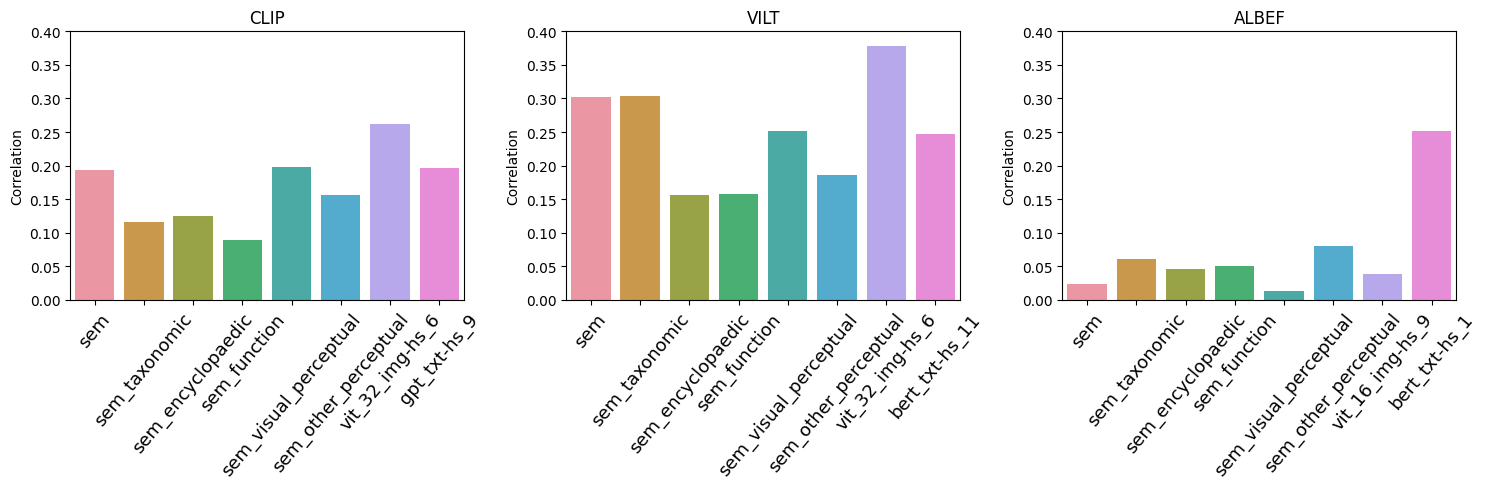

In [39]:
compare = {
    'clip': ['sem_mcrae', 'vit_32', 'gpt'], 
    'vilt':['sem_mcrae', 'vit_32', 'bert'],
    'albef': ['sem_mcrae', 'vit_16', 'bert']
}
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
for m, ax in zip(models, axes.flat):
    c_res = []
    for c in compare[m]:
        file = res_path / 'rsa' / f'{m}_pred_{c}.pkl'
        with open(file, 'rb') as f:
            res = pickle.load(f)
        res = pd.DataFrame(res, columns=['model', 'comparison_model', 'corr', 'p_val'])
        res['corr'] = - res['corr']
        if 'sem' not in c:
            res = res.loc[res['corr'].idxmax()].to_frame().T
        c_res.append(res)
    c_res = pd.concat(c_res)
    sns.barplot(
        x='comparison_model', y='corr', data=c_res, ax=ax
    )
    ax.set(ylim=(0, 0.4))
    ax.set(xlabel=None, ylabel='Correlation')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=50, size=13)
    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
    #           ncol=6, fancybox=True, shadow=True)
    ax.set_title(f'{m.upper()}')
plt.tight_layout()
plt.show()

Since this analysis shoes that many information comes from visual perceptual or text encoders, and since we saw these models also have human-like information (put plot in appendix?), we carried out a variance partitioning analysis.

In [ ]:
pred_var = {}
for m in models:
    m_var = pd.read_csv(project_path / 'results/rsa' / f'pred_var_{m}.csv', index_col=0)
    m_var.index = m_var.index.fillna('all')
    pred_var[m] = m_var
pred_var = pd.concat(pred_var)
pred_var = pred_var.reset_index().rename(columns={'level_0': 'model', 'level_1': 'feature_type', '0': 'r2'})

fig, ax = plt.subplots(figsize=(7,3))
sns.barplot(
    x='feature_type', y='r2', hue='model', data=pred_var, 
    order=features_order, hue_order=models, palette= models_palette
)
ax.set(ylim=(0, 0.06))
ax.set(xlabel=None, ylabel='Unique Variance Explained')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=6, fancybox=True, shadow=True)
plt.tight_layout()
plt.show()

vilt empata o gana, osea gana
clip mas feature dependent, por que clip puede performear tan bien en los visio perceptuales y enciclopedicas

tendria que tener un noise ceiling

- Show comparison of RSA of layers

In [ ]:
model_streams = [
    'clip_img', 'clip_txt', 'vilt_multi', 'vilt_multi_img', 'vilt_multi_txt', 
    'albef_img', 'albef_txt', 'albef_multi', 'albef_multi_img', 'albef_multi_txt'
]
hs_var = {}
for m in model_streams:
    hs_var[m] = (
        pd.read_csv(project_path / 'results/rsa' / f'hs_var_{m}.csv')
        .rename(columns={'Unnamed: 0': 'layer', 'Unnamed: 1': 'feature_type', '0': 'r2'})
        .fillna('all')
    )
hs_var = pd.concat(hs_var)
hs_var = (
    hs_var.loc[hs_var['feature_type'] == 'all']
    .reset_index().drop(columns=['feature_type', 'level_1'])
    .rename(columns={'level_0':'model'})
)
hs_var.loc[hs_var['model'].str.contains('multi')]

In [ ]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
for m, ax in zip(['img', 'txt', 'multi'], axes.flat):
    if m == 'multi':
        
    else:
        m_data = hs_var.loc[hs_var['model'].str.contains(m)]
    sns.lineplot(
        x='layer', y='r2', hue='feature_type', data=m_data, 
        marker='o', dashes=False, ax=ax, palette="husl"
    )
    ax.set(ylim=(0, 0.1))
    ax.set_title(m, fontsize=20)
    ax.tick_params(axis='y', labelsize=15)
    ax.tick_params(axis='x', labelsize=15)
    ax.get_legend().remove()
    ax.set(ylabel=None)

axes.flat[0].set_ylabel('r2', fontsize=15)
lines, labels = axes.flat[0].get_legend_handles_labels()
lgd = fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=6, fancybox=True, shadow=True, fontsize=18)

plt.tight_layout()
plt.show()

### 3) Does the conceptual development of V+L models resembles more to that of humans?

In humans the lexicalization is related to certain variables, like familiarity of the word, is perceptualness, etc.

- Show comparison with pyscholinguistic variables

### 4) For dual-stream models, is the conceptual behavior more predominantly informed by one of its streams?

- Show similarity of final decision with layers across streams

In [ ]:
corr_info = []
for m_info in multi_models_info:
    m = m_info['dnn']
    c_dist, c_labels = get_concept_match_distance(res_path, m, synsets_imgs)
    for stream in m_info['stream']:
        if stream == 'img':
            st = stream
        else:
            st = f'{stream}_concepts'
        for l in layers[f'{m}_{stream}']:
            l_f = project_path / 'results/rsa/distances' / f'{m}_{st}_{l}.pkl'
            with open(l_f, 'rb') as f:
                l_dist, l_labels = pickle.load(f)
            corr_coef, p_val = spearmanr(-c_dist, l_dist, nan_policy='omit')
            corr_info.append([m, st, l, corr_coef, np.round(p_val, 4)])
corr_info = pd.DataFrame(corr_info, columns=['model', 'stream', 'layer', 'corr', 'pval'])

In [ ]:
def plot_clip_corr():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    for stream, ax in zip(['img', 'txt_concepts'], axes.flat):
        i_plot = corr_info.loc[
            (corr_info['model']=='clip')
            & (corr_info['stream'] == stream)
        ]
        sns.barplot(
            x='layer', y='corr', data=i_plot, ax=ax
        )
        ax.set(ylim=(0, 0.4))
        ax.set(xlabel=stream, ylabel='RSA')
        # ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
        #           ncol=6, fancybox=True, shadow=True)
    plt.tight_layout()
    plt.show()
plot_clip_corr()

In [ ]:
def plot_albef_corr():
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    for stream, ax in zip(['img', 'txt_concepts', 'multi_concepts'], axes.flat):
        i_plot = corr_info.loc[
            (corr_info['model']=='albef')
            & (corr_info['stream'] == stream)
        ]
        sns.barplot(
            x='layer', y='corr', data=i_plot, ax=ax
        )
        ax.set(ylim=(-0.1, 0.1))
        ax.set(xlabel=stream, ylabel='RSA')
        # ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
        #           ncol=6, fancybox=True, shadow=True)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_albef_corr()

In [ ]:
def plot_vilt_corr():
    fig, ax = plt.subplots(figsize=(15,5))
    i_plot = corr_info.loc[
        (corr_info['model']=='vilt')
    ]
    sns.barplot(
        x='layer', y='corr', data=i_plot, ax=ax
    )
    ax.set(ylim=(0, 0.7))
    ax.set(xlabel='multi', ylabel='RSA')
    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
    #           ncol=6, fancybox=True, shadow=True)
    plt.tight_layout()
    plt.show()
plot_vilt_corr()

## B) Feature detection

### 1) Can V+L lexicalize features?

#### Recall

In [ ]:
# Compute correct labels of features
sem_ft_labels = torch.zeros(4928, 1863)
i = 0
for s, s_imgs in synsets_imgs.items():
    f_idx = fsk_info.loc[fsk_info['synsets'] == s]['features_idx'].tolist()
    for _ in s_imgs:
        sem_ft_labels[i, f_idx] = 1
        i += 1
sem_ft_labels = sem_ft_labels.to(torch.int32)

In [ ]:
rec = {}
for m in models:
    f_preds, f_labels = get_match(
        (project_path/'results'), m, synsets_imgs, center=True, m_type='Feature'
    )
    rec[m] = recall(torch.Tensor(f_preds), sem_ft_labels, average=None, num_classes=1863, top_k=39)
    print(f'Recall of {m.upper()} (%): {torch.mean(rec[m])} \n')

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,3))
for m, ax in zip(models, axes.flat):
    ax.hist(np.array(rec[m]), alpha=0.5, bins=np.linspace(0,1,10), label='Recall Values')
    ax.set_title(f'{m.upper()}')
    ax.set_ylim(0, 1100)
plt.tight_layout()
plt.show()

In [ ]:
print('Number of features with more than 50% recall:\n')
for m in models:
    print(f'{m.upper()}: {torch.sum(rec[m] > .5)}')

In [ ]:
print('Top 10 features:')
for m in models:
    print(f'{m.upper()}: {[sem_ft[f] for f in rec[m].topk(10)[1].tolist()]}\n')

#### Coverage Error

In [ ]:
for m in models:
    f_preds, f_labels = get_match(
        (project_path/'results'), m, synsets_imgs, center=True, m_type='Feature'
    )
    ce = coverage_error(torch.Tensor(f_preds), sem_ft_labels) / 1863
    print(f'Coverage error of {m.upper()} (%): {ce} \n')

#### Recall by feature type

In [ ]:
rec_f = []
for m in models:
    for f, f_idx in sem_ft_idx_by_type.items():
        f_mean = torch.mean(rec[m][f_idx]).detach().numpy()
        rec_f.append([m, f, f_mean])
rec_f = pd.DataFrame(rec_f, columns=['model', 'feature_type', 'recall'])
rec_f['recall'] = rec_f['recall'].astype(float)

fig, ax = plt.subplots(figsize=(7,3))
sns.barplot(
    x='feature_type', y='recall', hue='model', 
    data=rec_f, order=features_order, hue_order=models
)
ax.set(ylim=(0, 0.7))
ax.set(xlabel=None, ylabel='Accuracy')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=6, fancybox=True, shadow=True)
plt.tight_layout()
plt.show()

### 3) Is the conceptual behavior based on features similar to the obtained in the lexicalization task?

"A perceptual concept is a verbal stimulus that substitutes for the common formal features
of stimuli that define their class membership (e.g., chair)." https://files.eric.ed.gov/fulltext/EJ800990.pdf

In [ ]:
print(f'Correlation between concept distances and feature-based distances:')
for m in models:
    c_dist, c_labels = get_concept_match_distance(res_path, m, synsets_imgs, from_preds=True)
    f_dist, f_labels = get_feature_match_distance(res_path, m, synsets_imgs)
    corr, pval = spearmanr(-c_dist, f_dist)
    print(f'{m.upper()}: correlation of {np.round(corr,3)}, pval of {np.round(pval,3)}')

### 4) How does the detection of concepts depends on the detection of features?

In [ ]:
mi = {}
for m in models:
    mi_m = (
        pd.read_csv(res_path / 'mutual_info' / f'{m}.csv', index_col=0)
        .stack().to_frame().reset_index()
        .rename(columns={0: 'mutual information', 'level_0': 'synset', 'level_1': 'feature'})
    )
    mi_m
    mi_m['feature_type'] = mi_m['feature'].apply(lambda f: sem_ft_type[f])
    mi_m['sem_related'] = mi_m.apply(
        lambda row: True if row['feature'] in synset_features[row['synset']] else False,
        axis=1
    )
    f_preds, _ = get_match(
        (project_path/'results'), m, synsets_imgs, center=True, m_type='Feature', avg=True
    )
    f_preds = f_preds.reshape(-1)
    mi_m['match'] = list(f_preds)
    mi_m = mi_m[['synset', 'feature', 'feature_type', 'sem_related', 'mutual information', 'match']]
    mi_m['remove'] = mi_m.apply(
        lambda row: True if row['synset'].split('-')[0] in row['feature'] else False,
        axis=1
    )
    mi_m = mi_m.drop(mi_m.loc[mi_m['remove']==True].index)
    mi_m = mi_m.drop('remove', axis=1)
    mi[m] = mi_m

In [ ]:
for m in models:
    print(m.upper())    
    display(mi[m].groupby(['sem_related']).mean())

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,3))
for m, ax in zip(models, axes.flat):
    sns.histplot(
        data=mi[m].groupby(['sem_related', 'synset']).mean().reset_index(), 
        x='mutual information', hue='sem_related', ax=ax
    )
    ax.set_title(f'{m.upper()}')
plt.tight_layout()
plt.show()

In [ ]:
m = 'vilt'
sorted_data = mi[m].sort_values(by='mutual information', ascending=False)[:400]
sns.scatterplot(data=sorted_data, y='mutual information', x='match', hue='sem_related')
plt.show()

In [ ]:
from sklearn.cluster import KMeans

X = mi['clip'][['mutual information', 'match']].values
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

In [ ]:
m = 'clip'
s = synsets[2]
data = mi[m].loc[mi[m]['synset'] == s].sort_values(by='mutual information', ascending=False)[:30]
data

In [ ]:
c_preds, _ = get_match(
    (project_path/'results'), m, synsets_imgs, center=True,
) 
f_preds, _ = get_match(
    (project_path/'results'), m, synsets_imgs, center=True, m_type='Feature'
)

In [ ]:
plt.scatter(c_preds[:,3], f_preds[:, sem_ft_idx['a_bike']])

- Compute overlap with the databases of co-occurrances and glvoe
- Compute correlation to show that some are subset of not in the image

Idea: dicotimize results and get average feature value 